In [1]:
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.layers import Conv2D, Flatten, LeakyReLU
from tensorflow.keras.layers import Reshape, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
import tensorflow as tf
import os
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from dataset import data_to_labels

## 데이터 shape

In [3]:
x_train_origins, x_test_origins, x_train, x_test, y_train, y_test = data_to_labels()
print("x_shape: {}, y_shape: {}".format(x_train.shape, y_train.shape))

x_shape: (94, 280, 280, 1), y_shape: (94, 280, 280, 3)


## 모델

In [6]:
os.environ['CUDA_VISIBLE_DEVICES'] = "0"
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

In [4]:
### 네트워크 파라미터
input_shape = (280, 280, 1)
channels = 3
kernel_size = 3
latent_dim = 10

# CNN 필터 수
layer_filters = [64, 128, 256]

# encoder 모델
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs

# Conv2D(64)-Conv2D(128)-Conv2D(256)
for filters in layer_filters:
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               strides=2,
               padding='same')(x)
    x = LeakyReLU()(x)


shape = K.int_shape(x)

# latent vector
x = Flatten()(x)
latent = Dense(latent_dim, name='latent_vector')(x)

# encoder 인스턴스화
encoder = Model(inputs, latent, name='encoder')
encoder.summary()

# decoder 모델
latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
x = Dense(shape[1]*shape[2]*shape[3])(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)

# Conv2DTranspose(256)-Conv2DTranspose(128)-Conv2DTranspose(64)
for filters in layer_filters[::-1]:
    x = Conv2DTranspose(filters=filters,
                        kernel_size=kernel_size,
                        strides=2,
                        padding='same')(x)
    x = LeakyReLU()(x)

outputs = Conv2DTranspose(filters=channels,
                          kernel_size=kernel_size,
                          padding='same',
                          name='decoder_output')(x)
outputs = LeakyReLU()(outputs)

# decoder 인스턴스화
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

# autoencoder = encoder + decoder
autoencoder = Model(inputs, decoder(encoder(inputs)), name='autoencoder')
autoencoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 280, 280, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 140, 140, 64)      640       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 140, 140, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 70, 70, 128)       73856     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 70, 70, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 35, 35, 256)       295168    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 35, 35, 256)       0   

In [10]:
# prepare model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'autoencoder.{epoch:03d}.h5'
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

In [12]:
batch_size = 2
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=2,
                               verbose=1,
                               min_lr=0.5e-6)

checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True)

# Mean Square Error (MSE) loss function, Adam optimizer
autoencoder.compile(loss='mse', optimizer='adam')

## 학습

In [77]:
# called every epoch
callbacks = [checkpoint, lr_reducer]

# train the autoencoder
history = autoencoder.fit(x_train,
                y_train,
                validation_data=(x_test, y_test),
                epochs=40,
                batch_size=batch_size,
                callbacks=callbacks)

Epoch 1/40
47/47 [==============================] - ETA: 0s - loss: 0.6802
Epoch 00001: val_loss improved from inf to 0.43755, saving model to /home/ssoonan/Desktop/mechanics/saved_models/autoencoder.001.h5
47/47 [==============================] - 16s 347ms/step - loss: 0.6802 - val_loss: 0.4375 - lr: 0.0010
Epoch 2/40
47/47 [==============================] - ETA: 0s - loss: 0.3630
Epoch 00002: val_loss improved from 0.43755 to 0.34032, saving model to /home/ssoonan/Desktop/mechanics/saved_models/autoencoder.002.h5
47/47 [==============================] - 16s 345ms/step - loss: 0.3630 - val_loss: 0.3403 - lr: 0.0010
Epoch 3/40
47/47 [==============================] - ETA: 0s - loss: 0.2914
Epoch 00003: val_loss improved from 0.34032 to 0.30292, saving model to /home/ssoonan/Desktop/mechanics/saved_models/autoencoder.003.h5
47/47 [==============================] - 16s 348ms/step - loss: 0.2914 - val_loss: 0.3029 - lr: 0.0010
Epoch 4/40
47/47 [==============================] - ETA: 0s - 

Epoch 29/40
47/47 [==============================] - ETA: 0s - loss: 0.0866
Epoch 00029: val_loss did not improve from 0.18848

Epoch 00029: ReduceLROnPlateau reducing learning rate to 1.0000000409520217e-05.
47/47 [==============================] - 15s 323ms/step - loss: 0.0866 - val_loss: 0.1886 - lr: 3.1623e-05
Epoch 30/40
47/47 [==============================] - ETA: 0s - loss: 0.0856
Epoch 00030: val_loss did not improve from 0.18848
47/47 [==============================] - 15s 324ms/step - loss: 0.0856 - val_loss: 0.1885 - lr: 1.0000e-05
Epoch 31/40
38/47 [=======================>......] - ETA: 2s - loss: 0.0912

KeyboardInterrupt: 

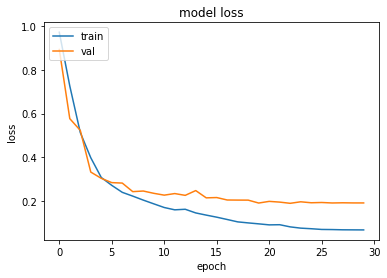

final val loss: 0.1904403120279312


In [140]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
print("final val loss: {}".format(history.history['val_loss'][-1]))

## 예측

In [5]:
# 학습한 weight loading
autoencoder.load_weights("weight.h5")

In [16]:
result = autoencoder.predict(x_test[:10])
i = 0

0


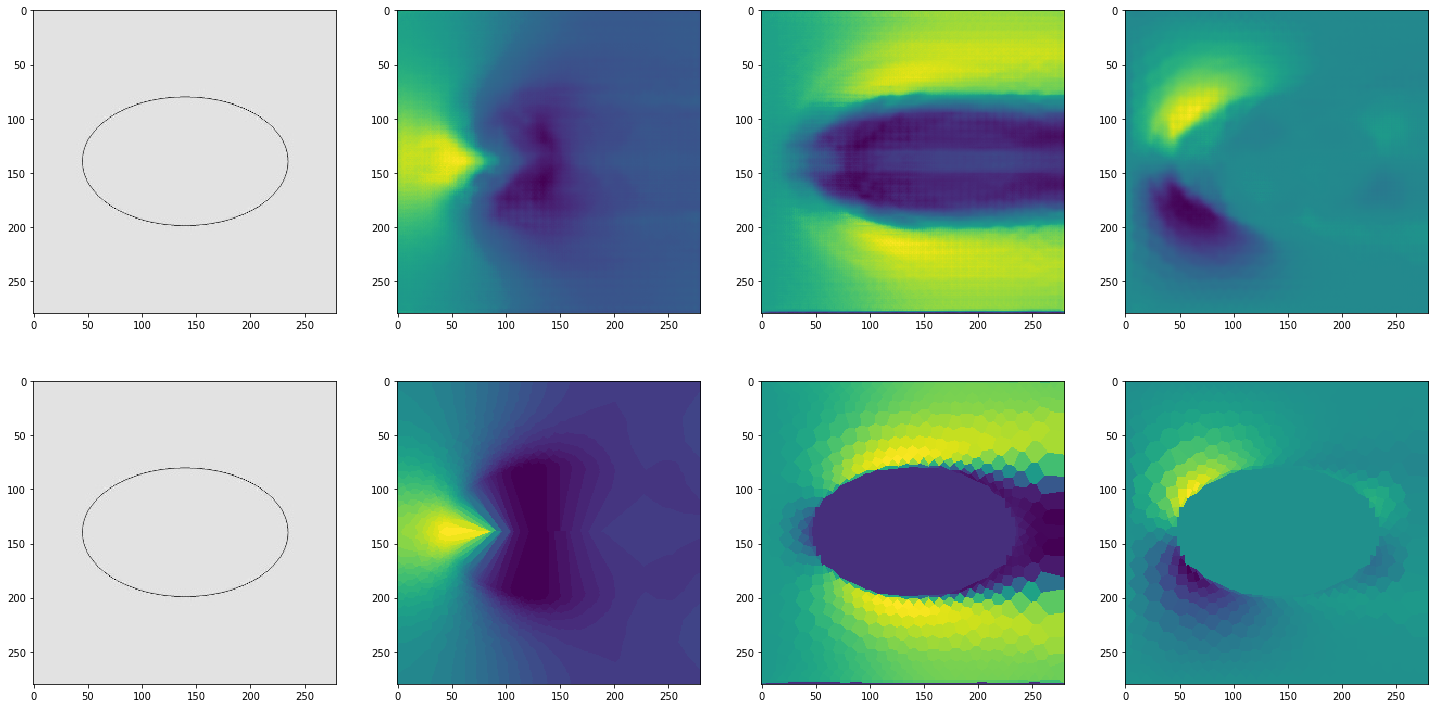

In [17]:
f = plt.figure(figsize=(25, 25))
print(i)
img = x_test_origins[i]
predicted_img = result[i]

# 위가 예측
ax1 = f.add_subplot(141)
ax1.imshow(img, cmap="gray")
ax2 = f.add_subplot(142)
ax2.imshow(predicted_img[:, :, 0])
ax3 = f.add_subplot(143)
ax3.imshow(predicted_img[:, :, 1])
ax4 = f.add_subplot(144)
ax4.imshow(predicted_img[:, :, 2])

# 밑이 실제 데이터
y_true = y_test[i]

ax5 = f.add_subplot(245)
ax5.imshow(img, cmap="gray")
ax6 = f.add_subplot(246)
ax6.imshow(y_true[:, :, 0])
ax7 = f.add_subplot(247)
ax7.imshow(y_true[:, :, 1])
ax8 = f.add_subplot(248)
ax8.imshow(y_true[:, :, 2])
i += 1